# Using pre-trained word embeddings in Neural Networks

**Original Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/05<br>
**Last modified:** 2020/05/05<br>
**Description:** Text classification on the Newsgroup20 dataset using pre-trained GloVe word embeddings.

## Setup

In [1]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow.data as tf_data
import keras
from keras import layers

## Introduction

In this example, we show how to train a text classification model that uses pre-trained
word embeddings.

We'll work with the Newsgroup20 dataset, a set of 20,000 message board messages
belonging to 20 different topic categories.

For the pre-trained word embeddings, we'll use
[GloVe embeddings](http://nlp.stanford.edu/projects/glove/).

## Let's take a look at the data

In [7]:
data_dir = pathlib.Path("../../data/20_newsgroup")
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of directories: 20
Directory names: ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
Number of files in comp.graphics: 1000
Some example filenames: ['38254', '38402', '38630', '38865', '38891']


Here's a example of what one file contains:

In [8]:
print(open(data_dir / "comp.graphics" / "38987").read())

Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Rensselaer Polytechnic Institute, Troy, NY.
Date: Thu, 29 Apr 1993 23:27:20 GMT
Lines: 7

Jasen Mabus
RPI student

	I am looking for a hman brain in any CAD (.dxf,.cad,.iges,.cgm,etc.) or picture (.gif,.jpg,.ras,etc.) format for an animation demonstration. If any has or knows of a location please reply by e-mail to mabusj@rpi.edu.

Thank you in advance,
Jasen Mabus  



As you can see, there are header lines that are leaking the file's category, either
explicitly (the first line is literally the category name), or implicitly, e.g. via the
`Organization` filed. Let's get rid of the headers:

In [9]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

There's actually one category that doesn't have the expected number of files, but the
difference is small enough that the problem remains a balanced classification problem.

## Shuffle and split the data into training & validation sets

In [33]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

# test
test_split = 0.5
num_test_samples = int(test_split * len(val_samples))
test_samples = val_samples[-num_test_samples:]
test_labels = val_labels[-num_test_samples:]

## Create a vocabulary index

Let's use the `TextVectorization` to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 20,000 words, and will truncate or pad sequences to
be actually 200 tokens long.

In [34]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf_data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

2025-04-04 12:10:27.403929: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


You can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top 5 words:

In [35]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

Let's vectorize a test sentence:

In [36]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3612, 1773,   15,    2, 6061])

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first
word in the vocabulary? That's because index 0 is reserved for padding and index 1 is
reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [37]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [38]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3612, 1773, 15, 2, 6061]

## Load pre-trained word embeddings

Let's download pre-trained GloVe embeddings (a 822M zip file).

You'll need to run the following commands:

In [17]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

--2025-04-04 11:59:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822,24M  5,04MB/s    in 2m 41s  

2025-04-04 12:02:04 (5,12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



The archive contains text-encoded vectors of various sizes: 50-dimensional,
100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [18]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained
vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [39]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17957 words (2043 misses)


Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.

Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to
update them during training).

In [40]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

## Build the model

A simple 1D convnet with global max pooling and a classifier at the end.

In [41]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 100)      │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 128)      │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, None, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,247,516 (8.57 MB)

 Trainable params: 247,316 (966.08 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

## Train the model

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [42]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

We use categorical crossentropy as our loss since we're doing softmax classification.
Moreover, we use `sparse_categorical_crossentropy` since our labels are integers.

In [43]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - acc: 0.0856 - loss: 2.9257 - val_acc: 0.2245 - val_loss: 2.2497
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - acc: 0.2567 - loss: 2.1792 - val_acc: 0.3987 - val_loss: 1.7158
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - acc: 0.4036 - loss: 1.7164 - val_acc: 0.5146 - val_loss: 1.4240
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.5043 - loss: 1.4189 - val_acc: 0.5131 - val_loss: 1.4483
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.5802 - loss: 1.2029 - val_acc: 0.4974 - val_loss: 1.5097
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.6272 - loss: 1.0706 - val_acc: 0.6028 - val_loss: 1.1854
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.6735 - loss: 0.9436 - val_acc: 0.5513 - val_loss: 1.4339
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.7007 - loss: 0.8577 - val_acc: 0.5673 - val_loss: 1.4363
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/

## Export an end-to-end model

Now, we may want to export a `Model` object that takes as input a string of arbitrary
length, rather than a sequence of indices. It would make the model much more portable,
since you wouldn't have to worry about the input preprocessing pipeline.

Our `vectorizer` is actually a Keras layer, so it's simple:

In [100]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model(
    keras.ops.convert_to_tensor(
        [["this message is about computer graphics and 3D modeling"]]
    )
)

print(class_names[np.argmax(probabilities[0])])

comp.graphics


In [101]:
y_test_prediction = model.predict(x_test)
y_test_prediction = np.argmax(y_test_prediction, axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


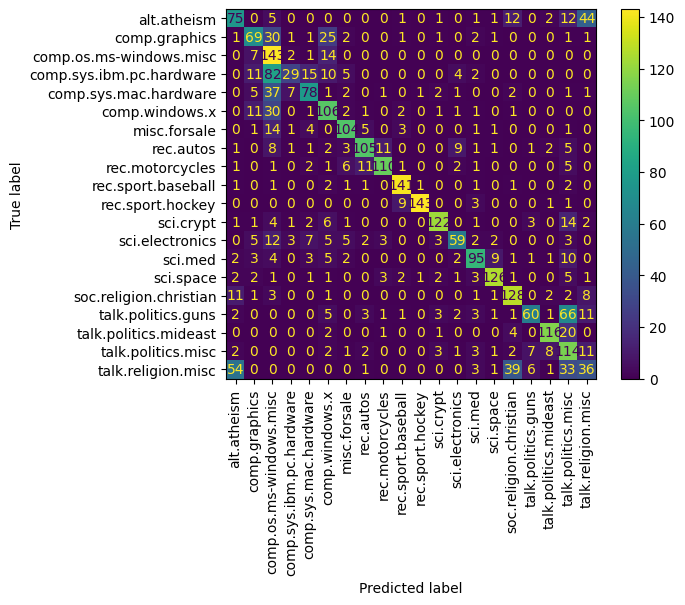

In [104]:
cm = confusion_matrix(y_test, y_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)

disp.plot(xticks_rotation=90)
plt.show()

In [105]:
print("Classification Report:\n", classification_report(y_test, y_test_prediction, target_names=class_names))

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.49      0.49      0.49       154
           comp.graphics       0.59      0.51      0.55       136
 comp.os.ms-windows.misc       0.38      0.86      0.53       167
comp.sys.ibm.pc.hardware       0.64      0.18      0.29       158
   comp.sys.mac.hardware       0.67      0.56      0.61       139
          comp.windows.x       0.56      0.68      0.61       157
            misc.forsale       0.78      0.77      0.77       135
               rec.autos       0.80      0.70      0.74       151
         rec.motorcycles       0.85      0.78      0.81       141
      rec.sport.baseball       0.88      0.93      0.90       152
        rec.sport.hockey       0.98      0.91      0.94       157
               sci.crypt       0.88      0.77      0.82       158
         sci.electronics       0.72      0.53      0.61       111
                 sci.med       0.77      0.69      